In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch.distributions as dist
from jaxtyping import Float, Int
from torch import Tensor
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
from spikeinterface.preprocessing import bandpass_filter
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.signal import find_peaks
import h5py

In [16]:
def load_mearec_data(recording_file="recordings.h5"):
    """
    Load MEArec data and convert to PyTorch tensors compatible with the notebook format
    """
    # Load MEArec data
    recording, sorting_true = se.read_mearec(recording_file)
    
    # Apply preprocessing (bandpass filter)
    recording_filt = bandpass_filter(recording, freq_min=300, freq_max=6000)
    
    # Get traces as numpy array and convert to torch tensor
    traces = torch.tensor(recording_filt.get_traces(), dtype=torch.float32)
    
    # Get ground truth spike times and IDs
    true_spike_times = []
    true_spike_ids = []
    
    for unit_id in sorting_true.unit_ids:
        unit_spikes = sorting_true.get_unit_spike_train(unit_id)
        true_spike_times.extend(unit_spikes)
        # Convert unit_id to integer (remove '#' if present)
        unit_idx = int(unit_id.lstrip('#')) if isinstance(unit_id, str) else int(unit_id)
        true_spike_ids.extend([unit_idx] * len(unit_spikes))
    
    # Sort by spike times
    sorted_indices = np.argsort(true_spike_times)
    true_spike_times = torch.tensor([true_spike_times[i] for i in sorted_indices], dtype=torch.long)
    true_spike_ids = torch.tensor([true_spike_ids[i] for i in sorted_indices], dtype=torch.long)
    
    # Extract true templates from MEArec data
    with h5py.File(recording_file, 'r') as f:
        templates = f['templates'][:]  # Shape: (n_units, n_jitters, n_channels, n_samples)
        
    # Convert templates to the expected format: (n_units, n_samples, n_channels)
    # Take median across jitters and transpose
    true_templates = torch.tensor(np.median(templates, axis=1).transpose(0, 2, 1), dtype=torch.float32)
    
    # Constants
    sampling_frequency = recording.sampling_frequency
    num_samples, num_channels = traces.shape
    true_num_spikes = len(true_spike_times)
    true_num_neurons, window_size, _ = true_templates.shape
    
    return {
        'traces': traces,
        'true_spike_times': true_spike_times,
        'true_spike_ids': true_spike_ids,
        'true_templates': true_templates,
        'sampling_frequency': sampling_frequency,
        'num_samples': num_samples,
        'num_channels': num_channels,
        'true_num_spikes': true_num_spikes,
        'true_num_neurons': true_num_neurons,
        'window_size': window_size
    }

In [17]:
data = load_mearec_data("data/sim_data/recordings2.h5")

# Extract variables in the same format as the original notebook
traces = data['traces']
true_spike_times = data['true_spike_times']
true_spike_ids = data['true_spike_ids']
true_templates = data['true_templates']

SAMPLING_FREQUENCY = data['sampling_frequency']
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = data['true_num_spikes']
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape

print(f"✅ Loaded MEArec data:")
print(f"   Traces shape: {traces.shape}")
print(f"   True spikes: {TRUE_NUM_SPIKES}")
print(f"   True neurons: {TRUE_NUM_NEURONS}")
print(f"   Sampling frequency: {SAMPLING_FREQUENCY} Hz")
print(f"   Window size: {WINDOW_SIZE}")

✅ Loaded MEArec data:
   Traces shape: torch.Size([1920000, 32])
   True spikes: 4805
   True neurons: 8
   Sampling frequency: 32000.0 Hz
   Window size: 416


In [12]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1
    
    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()
    
    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)
    
    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")
    
    # Plot the voltage traces
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1:
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

In [13]:
def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    
    fig, axs = plt.subplots(num_channels, num_waveforms,
                           figsize=(1.25 * num_waveforms, 1.25 * num_channels),
                           sharex=True, sharey=True)
    
    # Handle case where there's only one channel or one waveform
    if num_channels == 1:
        axs = axs.reshape(1, -1)
    if num_waveforms == 1:
        axs = axs.reshape(-1, 1)
    
    lim = 1.05 * waveforms.abs().max()
    
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    
    plt.tight_layout()
    return fig, axs

In [15]:
def evaluate_detected_spikes(
    detected_spike_times: Int[Tensor, "num_detected_spikes"],
    true_spike_times: Int[Tensor, "num_true_spikes"]) -> dict:
    """
    Evaluate detected spikes against ground truth with boundary handling
    """
    num_windows = NUM_SAMPLES // WINDOW_SIZE
    
    # Filter out spikes that would cause out-of-bounds errors
    # Keep only spikes that fall within valid window boundaries
    valid_true_spikes = true_spike_times[true_spike_times < num_windows * WINDOW_SIZE]
    valid_detected_spikes = detected_spike_times[detected_spike_times < num_windows * WINDOW_SIZE]
    
    # Create masks for windows containing spikes
    true_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_true_spikes) > 0:
        true_spike_mask[valid_true_spikes // WINDOW_SIZE] = True
    
    detected_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_detected_spikes) > 0:
        detected_spike_mask[valid_detected_spikes // WINDOW_SIZE] = True
    
    # Calculate confusion matrix elements
    tp = (true_spike_mask & detected_spike_mask).sum().item()
    fp = (detected_spike_mask & ~true_spike_mask).sum().item()
    fn = (~detected_spike_mask & true_spike_mask).sum().item()
    tn = (~detected_spike_mask & ~true_spike_mask).sum().item()
    
    return dict(tp=tp, fp=fp, fn=fn, tn=tn)

In [18]:
class SimpleSpikeSorter:
    """
    A simple spike sorter that uses a Gaussian mixture model (GMM) to fit the templates.
    """
    def __init__(self, initial_templates: Float[Tensor, "num_neurons window_size num_channels"],
                 noise_scale: float = 1.0) -> None:
        self.templates = initial_templates
        self.noise_scale = noise_scale

    @property
    def num_neurons(self) -> int:
        return self.templates.shape[0]

    def log_probability(self, spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
                       spike_ids: Int[Tensor, "num_spikes"]) -> float:
        """Compute the log probability of the spike waveforms given the templates"""
        assigned_templates = self.templates[spike_ids]
        ll = torch.distributions.Normal(assigned_templates, self.noise_scale).log_prob(spike_waveforms)
        ll = ll.sum().item()
        return ll

    def update_templates(self, spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
                        spike_ids: Int[Tensor, "num_spikes"]):
        """Update the templates using the spike waveforms and spike IDs"""
        for k in range(self.num_neurons):
            template_spikes = spike_waveforms[spike_ids == k]
            if len(template_spikes) > 0:
                self.templates[k] = template_spikes.mean(dim=0)

    def update_spike_ids(self, spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"]
                        ) -> Int[Tensor, "num_spikes"]:
        """Update the spike IDs using the templates and spike waveforms"""
        template_reshaped = self.templates.unsqueeze(1)
        waveforms_reshaped = spike_waveforms.unsqueeze(0)
        ll = torch.distributions.Normal(template_reshaped, self.noise_scale).log_prob(waveforms_reshaped)
        spike_ids = ll.sum(dim=(2,3)).argmax(dim=0)
        return spike_ids

    def fit(self, spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            num_iterations: int=10) -> tuple[Float[Tensor, "num_iterations"], Int[Tensor, "num_spikes"]]:
        """Fit the GMM to the spike waveforms using coordinate ascent"""
        # Initialize the spike IDs
        spike_ids = self.update_spike_ids(spike_waveforms)
        
        # Iterate to update the templates and spike IDs
        lps = []
        for itr in range(num_iterations):
            lps.append(self.log_probability(spike_waveforms, spike_ids))
            print(f"iteration {itr}: log probability = {lps[-1]:.2f}")
            
            # Update the templates and spike IDs
            self.update_templates(spike_waveforms, spike_ids)
            spike_ids = self.update_spike_ids(spike_waveforms)
        
        return torch.tensor(lps), spike_ids


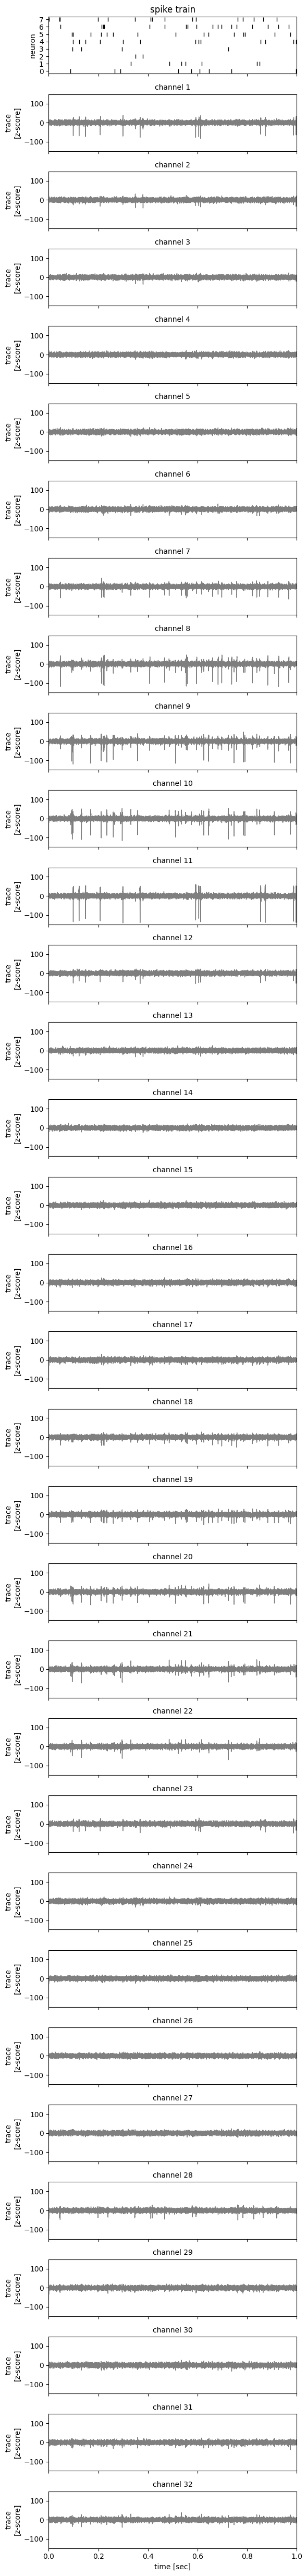

In [21]:
# Plot the first second of MEArec data
_ = plot_slice(traces, true_spike_times, true_spike_ids, start_time=0.0, end_time=1.0)

In [ ]:
# Plot true templates
fig, axs = plot_waveforms(true_templates, name="template")
fig.suptitle("MEArec True Templates", y=1.05)
plt.show()

Detected 14864 spikes
   Spike Detection Performance:
   Precision: 0.658
   Recall: 1.000

📈 Extracting spike waveforms...
✅ Extracted 14864 spike waveforms


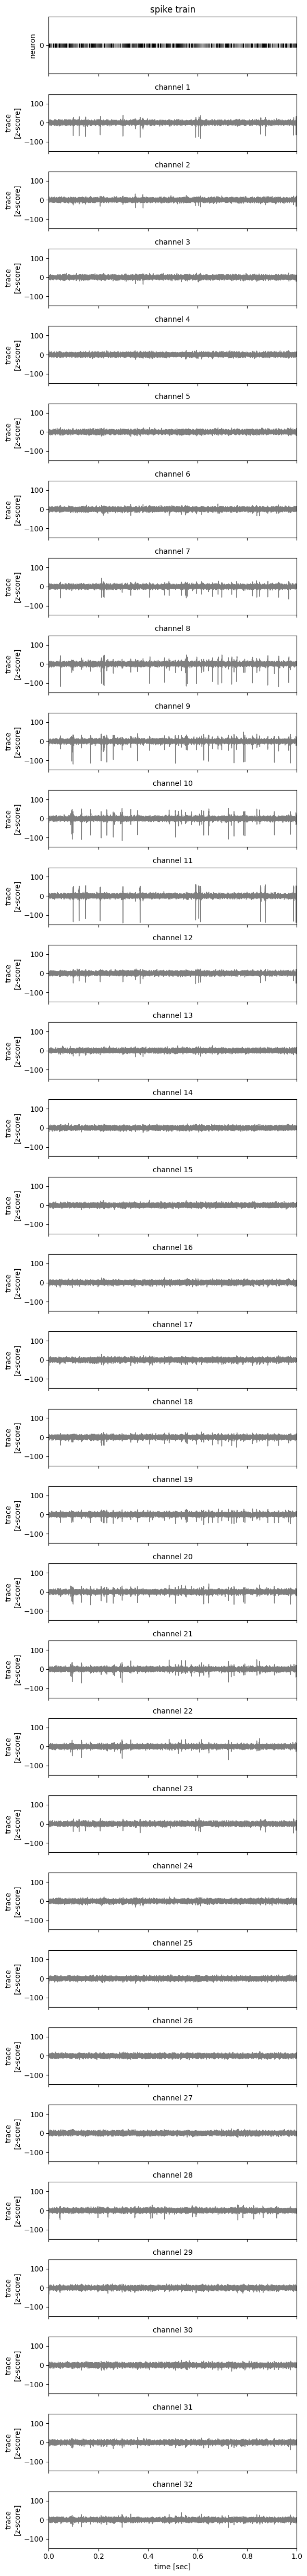

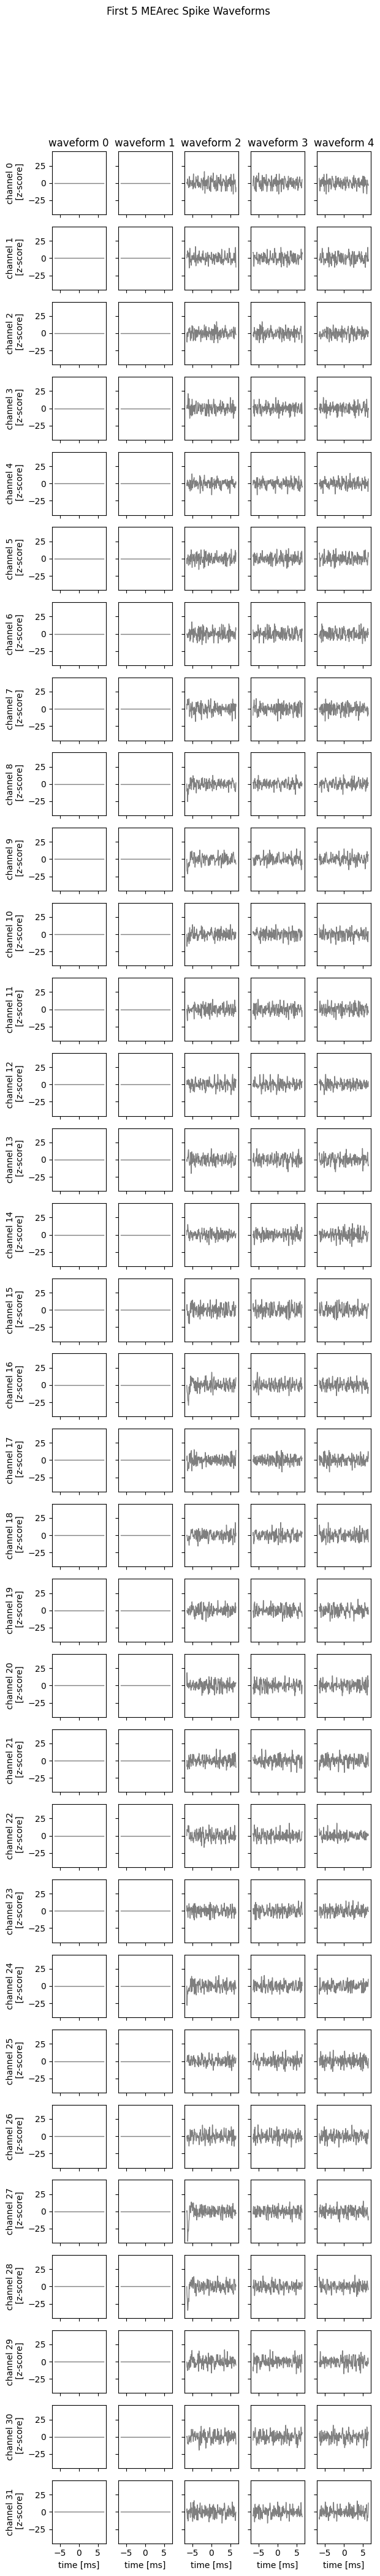

In [22]:
# Part 1: Detect spike times (adapted for MEArec)

# Compute minimum across channels and find negative peaks
min_height = traces.min(axis=1).values
detected_spike_times = find_peaks(-min_height, height=4, distance=3e-3*SAMPLING_FREQUENCY)

# Make sure the result is a tensor
detected_spike_times = torch.tensor(detected_spike_times[0])
num_detected_spikes = detected_spike_times.shape[0]

print(f"Detected {num_detected_spikes} spikes")

# Plot detected spikes
dummy_spike_ids = torch.zeros_like(detected_spike_times)
_ = plot_slice(traces, detected_spike_times, dummy_spike_ids, start_time=0., end_time=1.0)


# Evaluate spike detection
perf_stats = evaluate_detected_spikes(detected_spike_times, true_spike_times)
precision = perf_stats['tp'] / (perf_stats['tp'] + perf_stats['fp'])
recall = perf_stats['tp'] / (perf_stats['tp'] + perf_stats['fn'])

print(f"   Spike Detection Performance:")
print(f"   Precision: {precision:.3f}")
print(f"   Recall: {recall:.3f}")

# Extract spike waveforms
print("\n📈 Extracting spike waveforms...")
spike_waveforms = torch.zeros((num_detected_spikes, WINDOW_SIZE, NUM_CHANNELS))

for i, t in enumerate(detected_spike_times):
    slc = slice(t - WINDOW_SIZE // 2, t + WINDOW_SIZE // 2)
    if slc.start >= 0 and slc.stop < NUM_SAMPLES:
        spike_waveforms[i] = traces[slc]

print(f"✅ Extracted {num_detected_spikes} spike waveforms")

# Plot first few waveforms
fig, axs = plot_waveforms(spike_waveforms[:5], name="waveform")
fig.suptitle("First 5 MEArec Spike Waveforms", y=1.05)
plt.show()

In [ ]:
# Part 2: GMM Spike Sorting (using original SimpleSpikeSorter class)

# Initialize and run GMM spike sorting
num_neurons = TRUE_NUM_NEURONS  # Use the true number of neurons from MEArec
print(f"🎯 Running GMM spike sorting with {num_neurons} neurons...")

# Initialize with random spike waveforms as templates
torch.manual_seed(42)
initial_templates = spike_waveforms[torch.randint(0, num_detected_spikes, (num_neurons,))]

# Create and fit the spike sorter
spike_sorter = SimpleSpikeSorter(initial_templates, noise_scale=1.0)
lps, inferred_spike_ids = spike_sorter.fit(spike_waveforms, num_iterations=10)

# Plot convergence
plt.figure(figsize=(8, 4))
plt.plot(lps, '-o')
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.title("GMM Convergence")
plt.grid(True, alpha=0.3)
plt.show()

# Plot inferred templates
fig, axs = plot_waveforms(spike_sorter.templates, name="template")
fig.suptitle("GMM Inferred Templates", y=1.05)
plt.show()

In [ ]:

# Part 3: Evaluation against MEArec ground truth
print("\n🎯 Part 3: Evaluation against MEArec Ground Truth")

def match_true_and_inferred_spikes(inferred_spike_times: Int[Tensor, "num_detected_spikes"],
                                  true_spike_times: Int[Tensor, "num_true_spikes"],
                                  true_spike_ids: Int[Tensor, "num_true_spikes"]) -> Int[Tensor, "num_detected_spikes"]:
    """Match inferred spike times to true spike times"""
    matching_spike_ids = torch.full((inferred_spike_times.shape[0],), -1)
    
    for i, inferred_time in enumerate(inferred_spike_times):
        # Find the closest true spike within the window size
        match = torch.min(abs(true_spike_times - inferred_time), dim=0)
        if match.values < WINDOW_SIZE / 2:
            matching_spike_ids[i] = true_spike_ids[match.indices]
    
    return matching_spike_ids

# Match detected spikes to ground truth
matching_spike_ids = match_true_and_inferred_spikes(detected_spike_times, true_spike_times, true_spike_ids)

# Create confusion matrix
cm = confusion_matrix(matching_spike_ids, inferred_spike_ids)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="none", cmap=plt.cm.Blues)
num_rows, num_cols = cm.shape
plt.xticks(range(num_cols))
plt.yticks(range(num_rows))
plt.colorbar()
plt.xlabel('Inferred Cluster IDs')
plt.ylabel('True Neuron IDs (-1 = False Positive)')
plt.title("MEArec GMM Spike Sorting: Confusion Matrix")

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Calculate performance metrics
valid_matches = matching_spike_ids >= 0
if valid_matches.sum() > 0:
    ari = adjusted_rand_score(matching_spike_ids[valid_matches], inferred_spike_ids[valid_matches])
    print(f"📊 MEArec GMM Performance:")
    print(f"   Adjusted Rand Index: {ari:.3f}")
    print(f"   Matched spikes: {valid_matches.sum()}/{len(matching_spike_ids)}")
    print(f"   True neurons: {TRUE_NUM_NEURONS}")
    print(f"   Inferred clusters: {len(torch.unique(inferred_spike_ids))}")
else:
    print("❌ No valid matches found between detected and true spikes")

print("\n✅ MEArec GMM Spike Sorting Analysis Complete!")


🔧 Using SpikeInterface peak detection...


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

detect peaks using locally_exclusive (no parallelization):   0%|          | 0/60 [00:00<?, ?it/s]

✅ SpikeInterface detected 4710 spikes


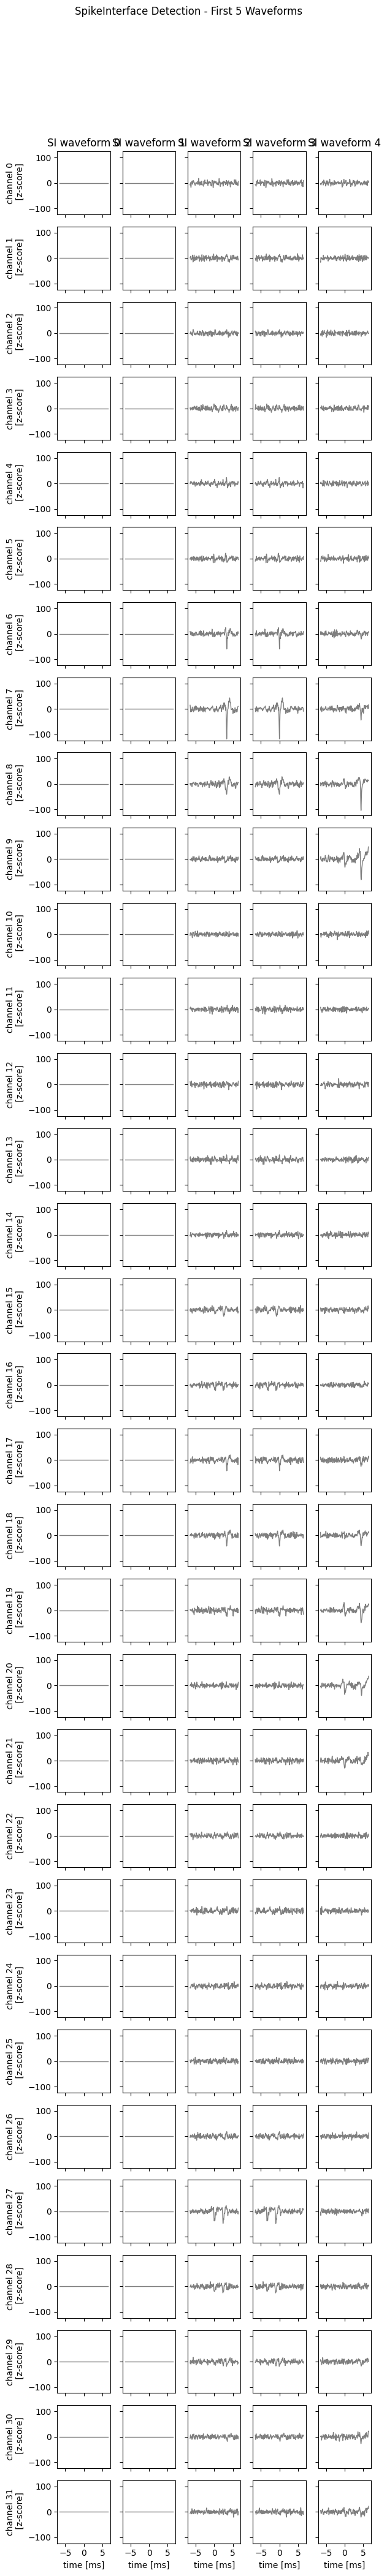

In [25]:
import spikeinterface.sorters as ss
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

# Use SpikeInterface's peak detection
print("🔧 Using SpikeInterface peak detection...")

# Convert back to SpikeInterface format temporarily
recording_si = se.read_mearec("data/sim_data/recordings2.h5")[0]
recording_filt = bandpass_filter(recording_si, freq_min=300, freq_max=6000)

# Detect peaks using SpikeInterface
peaks = detect_peaks(recording_filt, 
                    method='locally_exclusive',
                    peak_sign='neg',
                    detect_threshold=5.0,
                    exclude_sweep_ms=1.0)

# Convert back to torch tensors
si_spike_times = torch.tensor(peaks['sample_index'])
print(f"✅ SpikeInterface detected {len(si_spike_times)} spikes")

# Extract waveforms using SpikeInterface detection
spike_waveforms_si = torch.zeros((len(si_spike_times), WINDOW_SIZE, NUM_CHANNELS))
traces_np = recording_filt.get_traces()

for i, t in enumerate(si_spike_times):
    start_idx = t - WINDOW_SIZE // 2
    end_idx = t + WINDOW_SIZE // 2
    
    if start_idx >= 0 and end_idx < traces_np.shape[0]:
        spike_waveforms_si[i] = torch.tensor(traces_np[start_idx:end_idx])

# Plot SpikeInterface results
fig, axs = plot_waveforms(spike_waveforms_si[:5], name="SI waveform")
fig.suptitle("SpikeInterface Detection - First 5 Waveforms", y=1.05)
plt.show()


In [26]:
# Debug the spike detection and extraction
print("🔍 Debugging spike detection...")
print(f"Recording length: {traces_np.shape[0]} samples")
print(f"Window size: {WINDOW_SIZE} samples")
print(f"Half window: {WINDOW_SIZE // 2} samples")

# Check first 10 detected spike times
print(f"\nFirst 10 detected spike times:")
for i in range(min(10, len(si_spike_times))):
    t = si_spike_times[i]
    start_idx = t - WINDOW_SIZE // 2
    end_idx = t + WINDOW_SIZE // 2
    valid = start_idx >= 0 and end_idx < traces_np.shape[0]
    print(f"Spike {i}: time={t}, start={start_idx}, end={end_idx}, valid={valid}")

# Check the actual traces at these times
print(f"\nTrace values at first few spike times:")
for i in range(min(5, len(si_spike_times))):
    t = si_spike_times[i]
    if 0 <= t < traces_np.shape[0]:
        trace_val = traces_np.[t, :]
        print(f"Spike {i} at time {t}: {trace_val}")


SyntaxError: invalid syntax (4109121195.py, line 21)

Extracting waveforms with window size 416...
Skipping spike 0: out of bounds (start=-206, end=210)
Skipping spike 1: out of bounds (start=-200, end=216)
Skipping spike 4709: out of bounds (start=1919701, end=1920117)
✅ Extracted 4707 valid waveforms


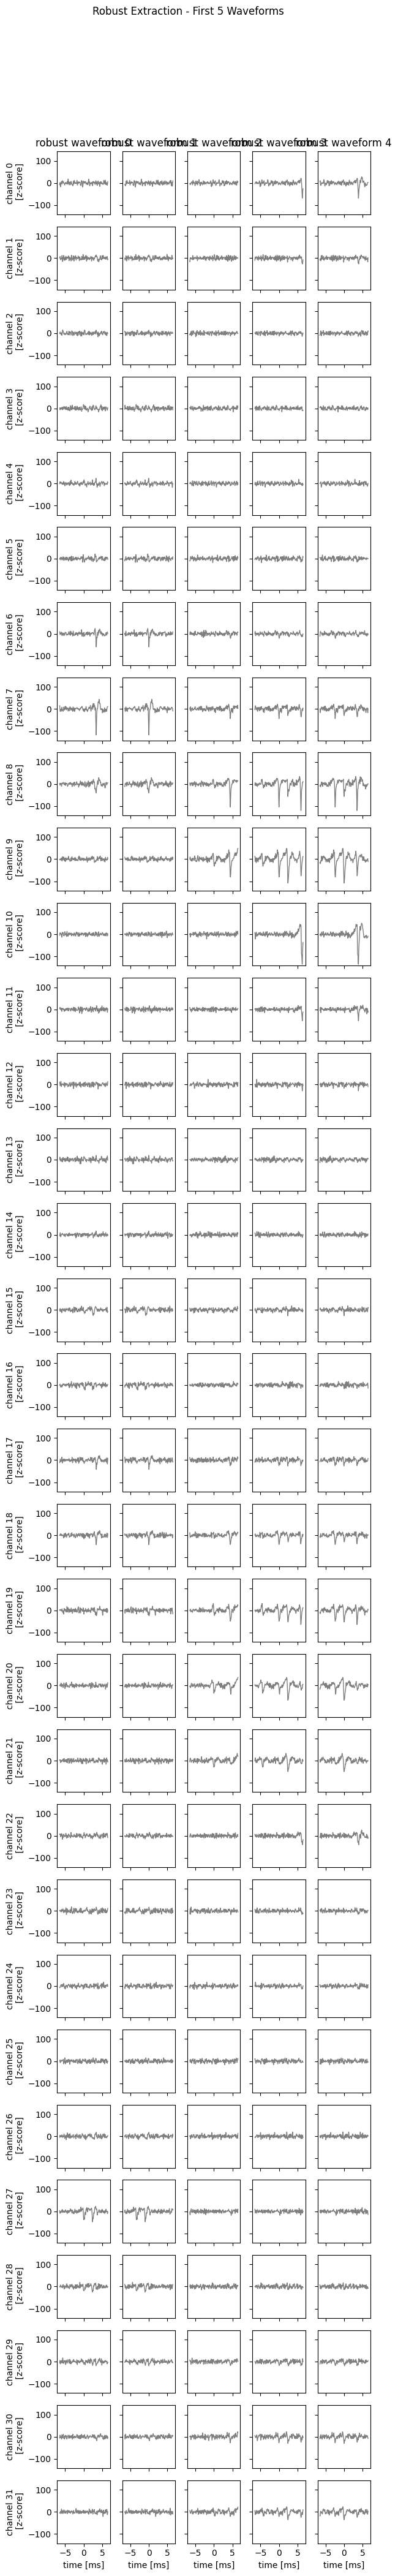

In [27]:
def extract_waveforms_robust(traces_np, spike_times, window_size):
    """
    Robust waveform extraction with proper boundary handling
    """
    num_spikes = len(spike_times)
    num_samples, num_channels = traces_np.shape
    half_window = window_size // 2
    
    spike_waveforms = []
    valid_spike_times = []
    
    print(f"Extracting waveforms with window size {window_size}...")
    
    for i, t in enumerate(spike_times):
        start_idx = int(t - half_window)
        end_idx = int(t + half_window)
        
        # Check boundaries
        if start_idx >= 0 and end_idx < num_samples:
            waveform = traces_np[start_idx:end_idx, :]
            
            # Verify we got the right shape
            if waveform.shape[0] == window_size:
                spike_waveforms.append(torch.tensor(waveform))
                valid_spike_times.append(t)
            else:
                print(f"Skipping spike {i}: wrong shape {waveform.shape}")
        else:
            print(f"Skipping spike {i}: out of bounds (start={start_idx}, end={end_idx})")
    
    if len(spike_waveforms) > 0:
        spike_waveforms = torch.stack(spike_waveforms)
        print(f"✅ Extracted {len(spike_waveforms)} valid waveforms")
    else:
        print("❌ No valid waveforms extracted!")
        spike_waveforms = torch.zeros((0, window_size, num_channels))
    
    return spike_waveforms, torch.tensor(valid_spike_times)

# Apply robust extraction
spike_waveforms_fixed, valid_spike_times = extract_waveforms_robust(
    traces_np, si_spike_times, WINDOW_SIZE
)

# Plot the results
if len(spike_waveforms_fixed) > 0:
    fig, axs = plot_waveforms(spike_waveforms_fixed[:5], name="robust waveform")
    fig.suptitle("Robust Extraction - First 5 Waveforms", y=1.05)
    plt.show()
else:
    print("No waveforms to plot!")



🎯 Running GMM spike sorting with 8 neurons...
iteration 0: log probability = -2661755904.00
iteration 1: log probability = -1514614144.00
iteration 2: log probability = -1459478272.00
iteration 3: log probability = -1441729280.00
iteration 4: log probability = -1439010816.00
iteration 5: log probability = -1424117120.00
iteration 6: log probability = -1412941056.00
iteration 7: log probability = -1412839296.00
iteration 8: log probability = -1412791808.00
iteration 9: log probability = -1412768256.00


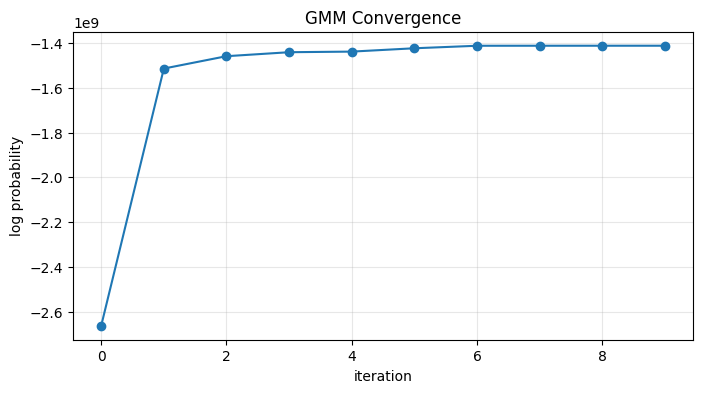

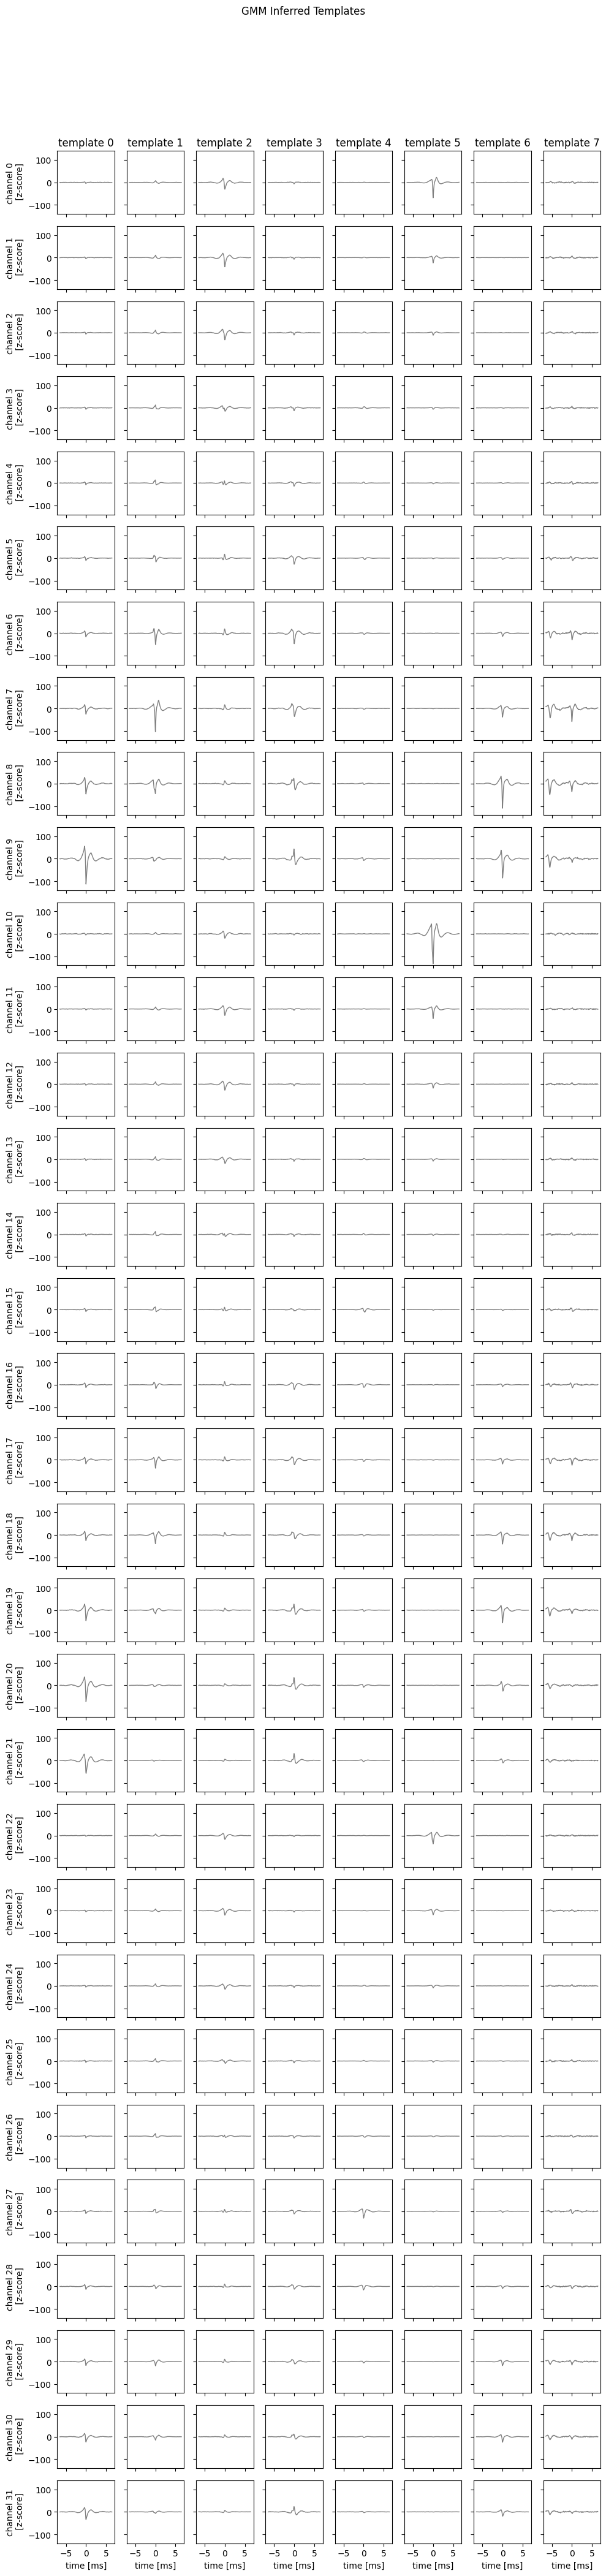

In [33]:
# Part 2: GMM Spike Sorting (using original SimpleSpikeSorter class)

# Initialize and run GMM spike sorting
num_neurons = TRUE_NUM_NEURONS  # Use the true number of neurons from MEArec
print(f"🎯 Running GMM spike sorting with {num_neurons} neurons...")

# Initialize with random spike waveforms as templates
torch.manual_seed(42)
initial_templates = spike_waveforms_fixed[torch.randint(0, len(valid_spike_times), (num_neurons,))]

# Create and fit the spike sorter
spike_sorter = SimpleSpikeSorter(initial_templates, noise_scale=1.0)
lps, inferred_spike_ids = spike_sorter.fit(spike_waveforms_fixed, num_iterations=10)

# Plot convergence
plt.figure(figsize=(8, 4))
plt.plot(lps, '-o')
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.title("GMM Convergence")
plt.grid(True, alpha=0.3)
plt.show()

# Plot inferred templates
fig, axs = plot_waveforms(spike_sorter.templates, name="template")
fig.suptitle("GMM Inferred Templates", y=1.05)
plt.show()

In [ ]:
# Part 3: Evaluation against MEArec ground truth
print("\n🎯 Part 3: Evaluation against MEArec Ground Truth")

def match_true_and_inferred_spikes(inferred_spike_times: Int[Tensor, "num_detected_spikes"],
                                  true_spike_times: Int[Tensor, "num_true_spikes"],
                                  true_spike_ids: Int[Tensor, "num_true_spikes"]) -> Int[Tensor, "num_detected_spikes"]:
    """Match inferred spike times to true spike times"""
    matching_spike_ids = torch.full((inferred_spike_times.shape[0],), -1)
    
    for i, inferred_time in enumerate(inferred_spike_times):
        # Find the closest true spike within the window size
        match = torch.min(abs(true_spike_times - inferred_time), dim=0)
        if match.values < WINDOW_SIZE / 2:
            matching_spike_ids[i] = true_spike_ids[match.indices]
    
    return matching_spike_ids

# Match detected spikes to ground truth
matching_spike_ids = match_true_and_inferred_spikes(detected_spike_times, true_spike_times, true_spike_ids)

# Create confusion matrix
cm = confusion_matrix(matching_spike_ids, inferred_spike_ids)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="none", cmap=plt.cm.Blues)
num_rows, num_cols = cm.shape
plt.xticks(range(num_cols))
plt.yticks(range(num_rows))
plt.colorbar()
plt.xlabel('Inferred Cluster IDs')
plt.ylabel('True Neuron IDs (-1 = False Positive)')
plt.title("MEArec GMM Spike Sorting: Confusion Matrix")

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Calculate performance metrics
valid_matches = matching_spike_ids >= 0
if valid_matches.sum() > 0:
    ari = adjusted_rand_score(matching_spike_ids[valid_matches], inferred_spike_ids[valid_matches])
    print(f"📊 MEArec GMM Performance:")
    print(f"   Adjusted Rand Index: {ari:.3f}")
    print(f"   Matched spikes: {valid_matches.sum()}/{len(matching_spike_ids)}")
    print(f"   True neurons: {TRUE_NUM_NEURONS}")
    print(f"   Inferred clusters: {len(torch.unique(inferred_spike_ids))}")
else:
    print("❌ No valid matches found between detected and true spikes")

print("\n✅ MEArec GMM Spike Sorting Analysis Complete!")



🎯 Part 3: Evaluation against MEArec Ground Truth


ValueError: Found input variables with inconsistent numbers of samples: [14864, 4707]

🎯 Evaluating GMM using ground truth spike times...
✅ Extracted 4802 ground truth waveforms


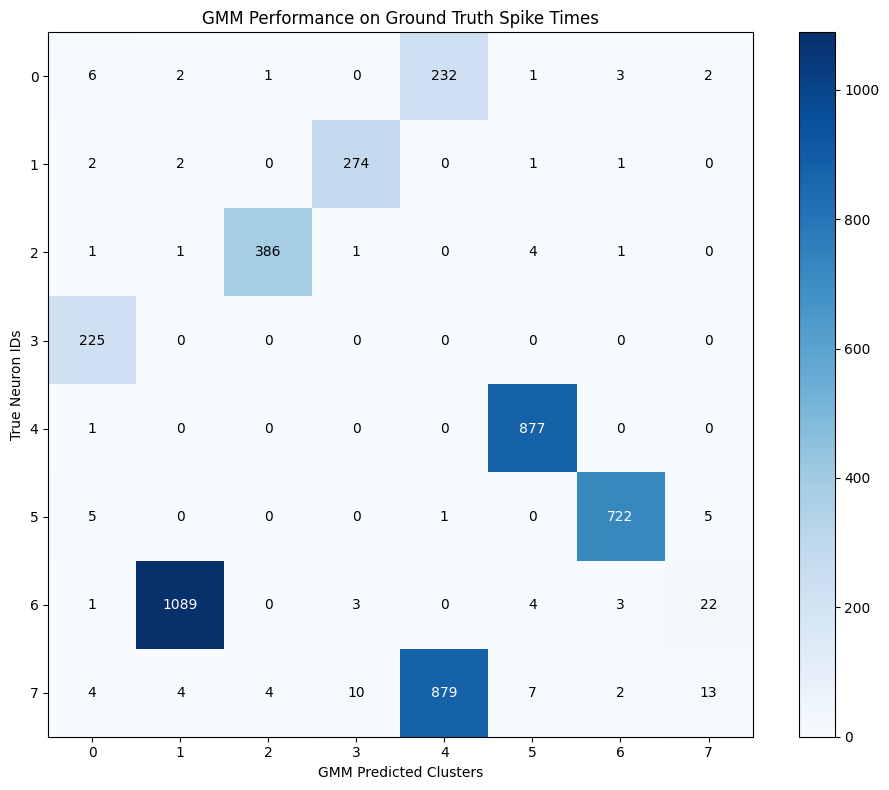

📊 GMM Performance on Ground Truth Spikes:
   Adjusted Rand Index: 0.895


In [31]:
# Alternative: Use ground truth spike times for cleaner evaluation
def evaluate_gmm_with_ground_truth(true_spike_times, true_spike_ids, traces, gmm_sorter):
    """
    Evaluate GMM using ground truth spike times
    """
    print("🎯 Evaluating GMM using ground truth spike times...")
    
    # Extract waveforms at ground truth locations
    gt_waveforms = []
    valid_gt_times = []
    valid_gt_ids = []
    
    for i, t in enumerate(true_spike_times):
        start_idx = t - WINDOW_SIZE // 2
        end_idx = t + WINDOW_SIZE // 2
        
        if start_idx >= 0 and end_idx < traces.shape[0]:
            waveform = traces[start_idx:end_idx]
            gt_waveforms.append(waveform)
            valid_gt_times.append(t)
            valid_gt_ids.append(true_spike_ids[i])
    
    gt_waveforms = torch.stack(gt_waveforms)
    valid_gt_ids = torch.tensor(valid_gt_ids)
    
    print(f"✅ Extracted {len(gt_waveforms)} ground truth waveforms")
    
    # Apply GMM to ground truth waveforms
    gmm_predictions = gmm_sorter.update_spike_ids(gt_waveforms)
    
    # Create confusion matrix
    cm_gt = confusion_matrix(valid_gt_ids.numpy(), gmm_predictions.numpy())
    
    return cm_gt, valid_gt_ids, gmm_predictions

# Apply ground truth evaluation
cm_gt, gt_ids, gmm_pred = evaluate_gmm_with_ground_truth(
    true_spike_times, true_spike_ids, traces, spike_sorter
)

# Plot ground truth-based confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_gt, interpolation="none", cmap=plt.cm.Blues)
plt.xticks(range(cm_gt.shape[1]))
plt.yticks(range(cm_gt.shape[0]))
plt.colorbar()
plt.xlabel('GMM Predicted Clusters')
plt.ylabel('True Neuron IDs')
plt.title("GMM Performance on Ground Truth Spike Times")

for i in range(cm_gt.shape[0]):
    for j in range(cm_gt.shape[1]):
        plt.text(j, i, str(cm_gt[i, j]), ha='center', va='center',
                color='white' if cm_gt[i, j] > cm_gt.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Calculate ARI for ground truth evaluation
ari_gt = adjusted_rand_score(gt_ids.numpy(), gmm_pred.numpy())
print(f"📊 GMM Performance on Ground Truth Spikes:")
print(f"   Adjusted Rand Index: {ari_gt:.3f}")
